# ***人脸识别与神经风格迁移***

# 1. 人脸验证和人脸识别

① 首先简单介绍一下人脸验证（face verification）和人脸识别（face recognition）的区别。

 - 人脸验证：输入一张人脸图片，验证输出与模板是否为同一人，即一对一问题。
 - 人脸识别：输入一张人脸图片，验证输出是否为K个模板中的某一个，即一对多问题。

② 一般地，人脸识别比人脸验证更难一些。因为假设人脸验证系统的错误率是1%，那么在人脸识别中，输出分别与K个模板都进行比较，则相应的错误率就会增加，约K%。模板个数越多，错误率越大一些。

# 2. One Shot Learning

① One-shot learning就是说数据库中每个人的训练样本只包含一张照片，然后训练一个CNN模型来进行人脸识别。

② 若数据库有K个人，则CNN模型输出softmax层就是K维的。

③ 但是One-shot learning的性能并不好，其包含了两个缺点：
 - 每个人只有一张图片，训练样本少，构建的CNN网络不够健壮。
 - 若数据库增加另一个人，输出层softmax的维度就要发生变化，相当于要重新构建CNN网络，使模型计算量大大增加，不够灵活。

① 为了解决One-shot learning的问题，我们先来介绍相似函数（similarity function）。

② 相似函数表示两张图片的相似程度，用d(img1,img2)来表示。若d(img1,img2)较小，则表示两张图片相似；若d(img1,img2)较大，则表示两张图片不是同一个人。

③ 相似函数可以在人脸验证中使用：

 - d(img1,img2)≤τ : 一样
 - d(img1,img2)>τ : 不一样

④ 对于人脸识别问题，则只需计算测试图片与数据库中K个目标的相似函数，取其中d(img1,img2)最小的目标为匹配对象。

⑤ 若所有的d(img1,img2)都很大，则表示数据库没有这个人。

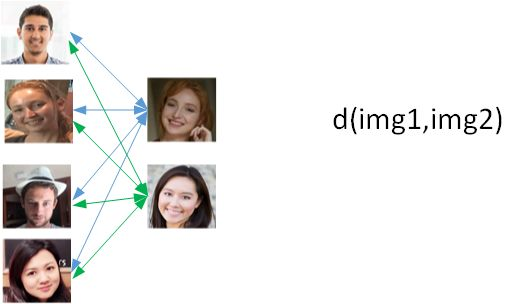

# 3. Siamese Network

① 若一张图片经过一般的CNN网络（包括CONV层、POOL层、FC层），最终得到全连接层FC，该FC层可以看成是原始图片的编码encoding，表征了原始图片的关键特征。

② 这个网络结构我们称之为Siamese network。

③ 也就是说每张图片经过Siamese network后，由FC层每个神经元来表征。

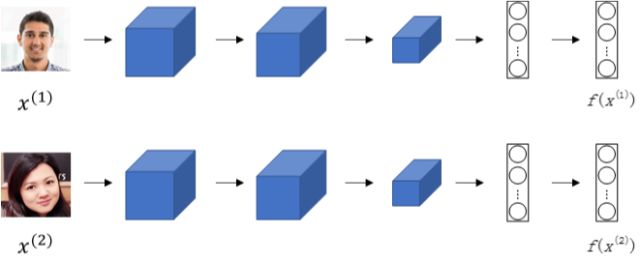

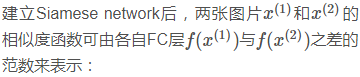

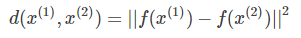

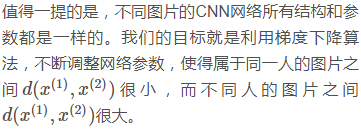

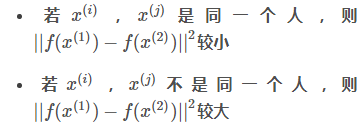

④ 具体网络构建和训练参数方法我们下一节再详细介绍。

# 4. Triplet Loss

① 构建人脸识别的CNN模型，需要定义合适的损失函数，这里我们将引入Triplet Loss。

② Triplet Loss需要每个样本包含三张图片：靶目标（Anchor）、正例（Positive）、反例（Negative），这就是triplet名称的由来。

③ 顾名思义，靶目标和正例是同一人，靶目标和反例不是同一人。

④ Anchor和Positive组成一类样本，Anchor和Negative组成另外一类样本。

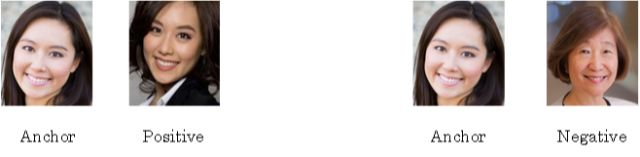

① 我们希望上一小节构建的CNN网络输出编码f(A)接近f(D)，即$||f(A)−f(D)||^2$尽可能小，而$||f(A)−f(N)||^2$尽可能大，数学上满足：

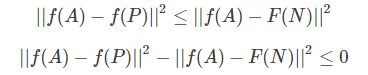

② 根据上面的不等式，如果所有的图片都是零向量，即f(A)=0,f(P)=0,f(N)=0，那么上述不等式也满足。

③ 但是这对我们进行人脸识别没有任何作用，是不希望看到的。我们希望得到$||f(A)−f(P)||^2$远小于$||f(A)−F(N)||^2$。

④ 所以，我们添加一个超参数α，且α>0，对上述不等式做出如下修改：

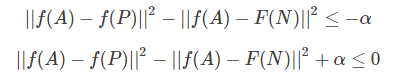

⑤ 顺便提一下，这里的α也被称为边界margin，类似与支持向量机中的margin。

⑥ 举个例子，若d(A,P)=0.5，α=0.2，则d(A,N)≥0.7。

⑦ 接下来，我们根据A，P，N三张图片，就可以定义Loss function为：

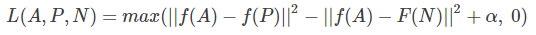

⑧ 相应地，对于m组训练样本，cost function为：

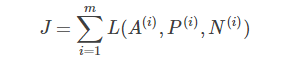

① 关于训练样本，必须保证同一人包含多张照片，否则无法使用这种方法。

② 例如10k张照片包含1k个不同的人脸，则平均一个人包含10张照片。这个训练样本是满足要求的。

③ 然后，就可以使用梯度下降算法，不断训练优化CNN网络参数，让J不断减小接近0。

④ 同一组训练样本，A，P，N的选择尽可能不要使用随机选取方法。因为随机选择的A与P一般比较接近，A与N相差也较大，毕竟是两个不同人脸。

⑤ 这样的话，也许模型不需要经过复杂训练就能实现这种明显识别，但是抓不住关键区别。所以，最好的做法是人为选择A与P相差较大（例如换发型，留胡须等），A与N相差较小（例如发型一致，肤色一致等）。

⑥ 这种人为地增加难度和混淆度会让模型本身去寻找学习不同人脸之间关键的差异，“尽力”让d(A,P)更小，让d(A,N)更大，即让模型性能更好。

⑦ 下面给出一些A，P，N的例子：

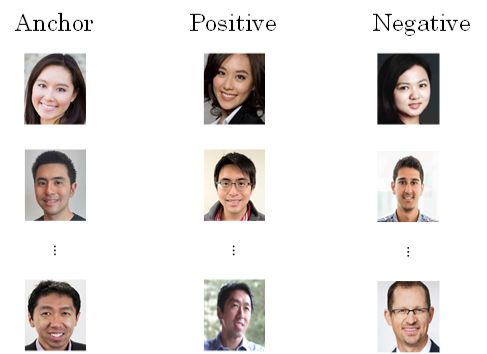

① 值得一提的是，现在许多商业公司构建的大型人脸识别模型都需要百万级别甚至上亿的训练样本。

② 如此之大的训练样本我们一般很难获取。但是一些公司将他们训练的人脸识别模型发布在了网上，可供我们使用。

# 5. 人脸验证和二元分类

① 除了构造triplet loss来解决人脸识别问题之外，还可以使用二分类结构。

② 做法是将两个siamese网络组合在一起，将各自的编码层输出经过一个逻辑输出单元，该神经元使用sigmoid函数，输出1则表示识别为同一人，输出0则表示识别为不同人。

③ 结构如下：

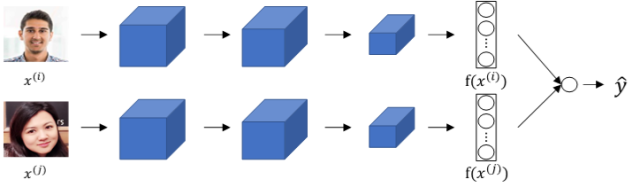

① 每组训练样本包含两张图片，每个siamese网络结构和参数完全相同。

② 这样就把人脸识别问题转化成了一个二分类问题。引入逻辑输出层参数$w_k$和$b$，输出y^表达式为：

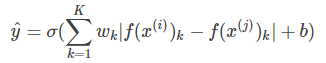

③ 其中参数$w_k$和$b$都是通过梯度下降算法迭代训练得到。

④ y^的另外一种表达式为：

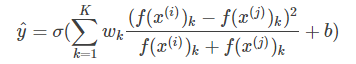

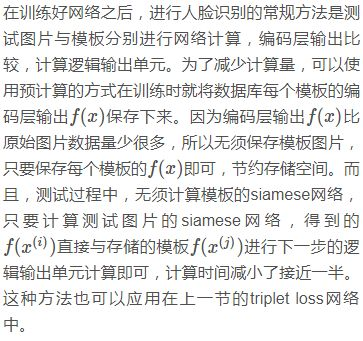

# 6. 神经风格迁移例图

① 神经风格迁移是CNN模型一个非常有趣的应用。它可以实现将一张图片的风格“迁移”到另外一张图片中，生成具有其特色的图片。

② 比如我们可以将毕加索的绘画风格迁移到我们自己做的图中，生成类似的“大师作品”，很酷不是吗？

③ 下面列出几个神经风格迁移的例子：

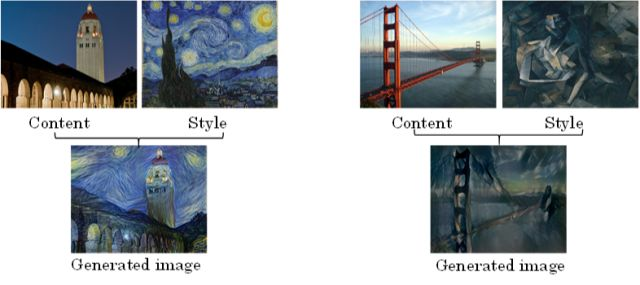

④ 一般用C表示内容图片，S表示风格图片，G表示生成的图片。

# 7. 神经风格迁移网络

① 在进行神经风格迁移之前，我们先来从可视化的角度看一下卷积神经网络每一层到底是什么样子？它们各自学习了哪些东西。

② 典型的CNN网络如下所示：

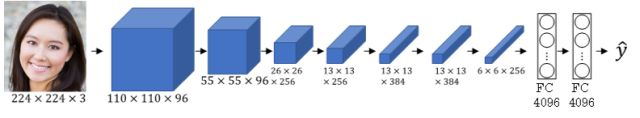

① 首先来看第一层隐藏层，遍历所有训练样本，找出让该层激活函数输出最大的9块图像区域；然后再找出该层的其它单元（不同的滤波器通道）激活函数输出最大的9块图像区域；最后共找9次，得到9 x 9的图像如下所示，其中每个3 x 3区域表示一个运算单元。

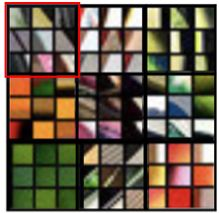

② 可以看出，第一层隐藏层一般检测的是原始图像的边缘和颜色阴影等简单信息。

③ 继续看CNN的更深隐藏层，随着层数的增加，捕捉的区域更大，特征更加复杂，从边缘到纹理再到具体物体。

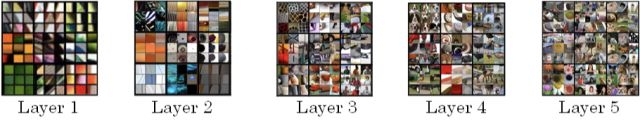

# 8. 神经风格迁移损失

① 神经风格迁移生成图片G的cost function由两部分组成：C与G的相似程度和S与G的相似程度。

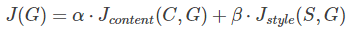

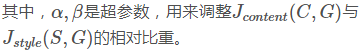

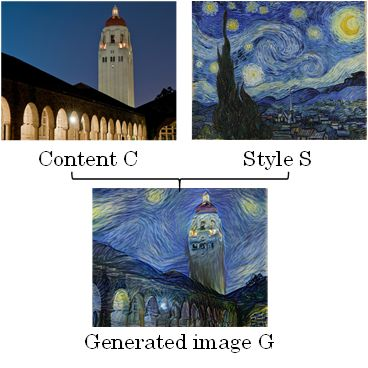

② 神经风格迁移的基本算法流程是：首先令G为随机像素点，然后使用梯度下降算法，不断修正G的所有像素点，使得J(G)不断减小，从而使G逐渐有C的内容和G的风格，如下图所示。

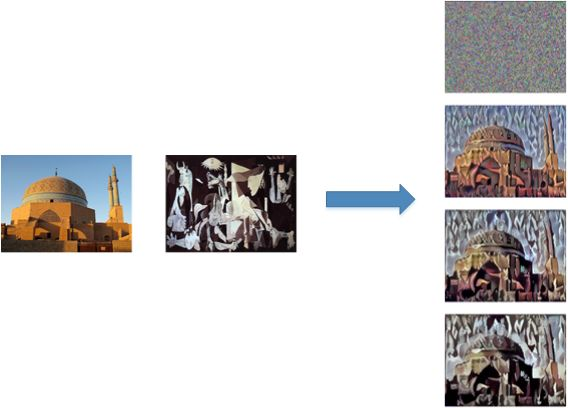

① 我们先来看J(G)的第一部分Jcontent(C,G)，它表示内容图片C与生成图片G之间的相似度。

② 使用的CNN网络是之前训练好的模型，例如Alex-Net。C，S，G共用相同模型和参数。

③ 首先，需要选择合适的层数l来计算Jcontent(C,G)。

④ 根据上面的内容，CNN的每个隐藏层分别提取原始图片的不同深度特征，由简单到复杂。

⑤ 如果l太小，则G与C在像素上会非常接近，没有迁移效果；如果l太深，则G上某个区域将直接会出现C中的物体。

⑥ 因此，l既不能太浅也不能太深，一般选择网络中间层。

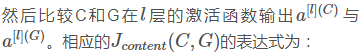

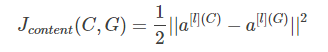

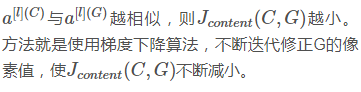

① 什么是图片的风格？利用CNN网络模型，图片的风格可以定义成第l层隐藏层不同通道间激活函数的乘积（相关性）。

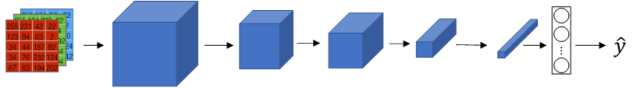

② 例如我们选取第l层隐藏层，其各通道使用不同颜色标注，如下图所示。

③ 因为每个通道提取图片的特征不同，比如1通道（红色）提取的是图片的垂直纹理特征，2通道（黄色）提取的是图片的橙色背景特征。

④ 那么计算这两个通道的相关性大小，相关性越大，表示原始图片及既包含了垂直纹理也包含了该橙色背景；相关性越小，表示原始图片并没有同时包含这两个特征。

⑤ 也就是说，计算不同通道的相关性，反映了原始图片特征间的相互关系，从某种程度上刻画了图片的“风格”。

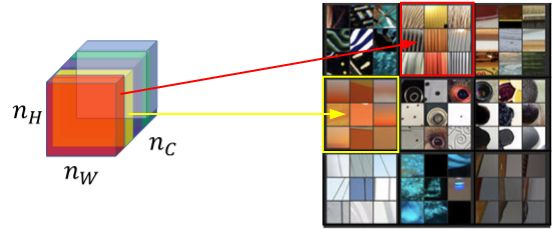

① 接下来我们就可以定义图片的风格矩阵（style matrix）为：

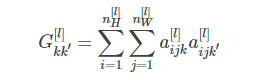

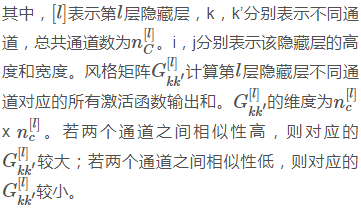

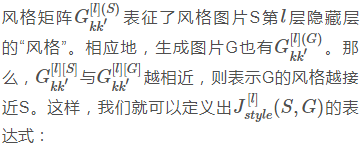

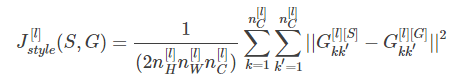

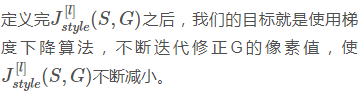

② 值得一提的是，以上我们只比较计算了一层隐藏层l。

③ 为了提取的“风格”更多，也可以使用多层隐藏层，然后相加，表达式为：

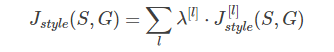

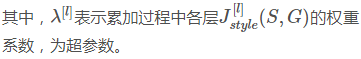

④ 根据以上两小节的推导，最终的cost function为：

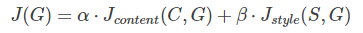

⑤ 使用梯度下降算法进行迭代优化。

# 9. 1D and 3D 卷积

① 我们之前介绍的CNN网络处理的都是2D图片，举例来介绍2D卷积的规则：

 - 输入图片维度：14 x 14 x 3
 - 滤波器尺寸：5 x 5 x 3，滤波器个数：16
 - 输出图片维度：10 x 10 x 16

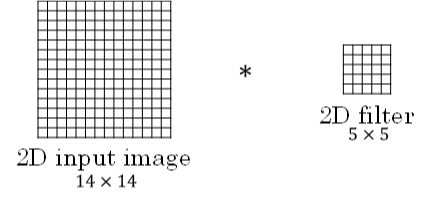

② 将2D卷积推广到1D卷积，举例来介绍1D卷积的规则：

 - 输入时间序列维度：14 x 1
 - 滤波器尺寸：5 x 1，滤波器个数：16
 - 输出时间序列维度：10 x 16

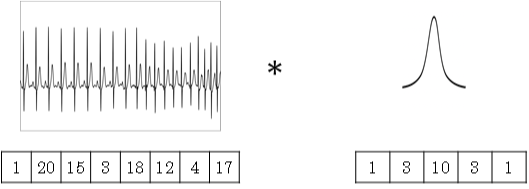

③ 对于3D卷积，举例来介绍其规则：

 - 输入3D图片维度：14 x 14 x 14 x 1
 - 滤波器尺寸：5 x 5 x 5 x 1，滤波器个数：16
 - 输出3D图片维度：10 x 10 x 10 x 16

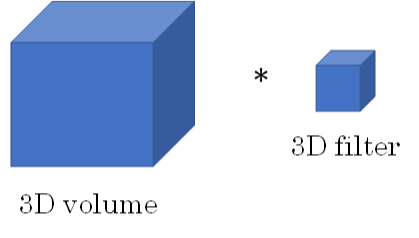